## Notebook : Active learning method comparison and implementation

### Outline

* [Initialization](#init)
* [Feature extraction and prediction](#feat-extract)
* [Core set selection with DBSCAN Clustering](#select-dbscan)
* [Core set selection with KMeans Clustering](#select-kmean)
* [Uncertainty Sampling](#u-sampling)



### Initialization
<a id="init"></a>
Import modules and set data directory


In [1]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import shutil
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch.multiprocessing as mp
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
from matplotlib.patches import Circle
import pickle

# Custom imports
from utils.preprocessing import ImageDataset, custom_collate
from utils.architectures import EffNetB0, CustomUnet
from utils.DCoM import DCoM

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


c:\Users\Alexandre Bonin\Documents\Stage\active-learning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Select model to use and set parameters

In [2]:
# mode = 'segmentation'
# data_path = r'C:\Users\Alexandre Bonin\Documents\Stage\datasets\Dataset_fixe_2024'
# model_path = r'C:\Users\Alexandre Bonin\Documents\Stage\Code segmentation (Leo)\Models\VL_2024+basemodelproxicam.pt'
# model = CustomUnet(encoder_name="resnet50",
#             encoder_weights="imagenet",
#             classes = 2,
#             activation=None,
#             encoder_depth=5,
#             decoder_channels=[256, 128, 64, 32, 16],
#             extract_features=True
#             ).to(device)

mode = 'classification'
data_path = r'C:\Users\Alexandre Bonin\Documents\Stage\datasets\ProspectFD\sample_PFD'
model_path = r'C:\Users\Alexandre Bonin\Documents\Stage\Classification-model-IMS\models\Run_2024-10-16_14-15-17.pth'
model = EffNetB0(num_classes=2, model_path = model_path, extract_features = True).to(device)

budgetSize = 50
batch_size = 64

save_pred_df = True # Save the pred_df in a pickle file ?
save_samples = True # Save the sampled images in a new directory ?

output_dir = os.path.join(data_path + '/DCoM')


if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

model.eval();


c:\Users\Alexandre Bonin\Documents\Stage\active-learning\utils\architectures.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(self.model_

## Feature extraction and prediction 
<a id="feat-extract"></a>
Extract features from images and make predictions

In [3]:
features = []
pseudo_labels = []


features_file = os.path.join(output_dir, 'features.pkl')
pred_file = os.path.join(output_dir, 'pred_df.pkl')
pseudo_labels_file = os.path.join(output_dir, 'pseudo_labels.pkl')

# Iterate over the images in the directory
img_list = [fname for fname in os.listdir(data_path) if fname.endswith(('jpg', 'jpeg', 'png'))]
img_list = [img_name for img_name in img_list[:500]]

# Initialize a DataFrame to store file paths and prediction probabilities
pred_df = pd.DataFrame(columns=['img_name', 'pred', 'delta', 'true_label'])
pred_backup = False 
# pred_df['img_name'] = img_list


# # Check if the pickle files exist
# if os.path.exists(features_file) :
#     print("Loading features from pickle files...")
#     with open(features_file, 'rb') as f:
#         features = pickle.load(f)

# if os.path.exists(pseudo_labels_file):
#     print("Loading predictions from pickle files...")

#     with open(pseudo_labels_file, 'rb') as f:
#         pseudo_labels = pickle.load(f)

# if os.path.exists(pred_file): #Make sure it is the right file
#     print("Loading pred_df from pickle files...")
#     pred_backup = True
#     # Load the variables from the pickle files
#     with open(pred_file, 'rb') as f:
#         pred_df = pickle.load(f)


if mp.get_start_method(allow_none=True) != 'spawn':
    mp.set_start_method('spawn', force=True)

num_workers = (8 if device.type == 'cuda' else 0)
print(f'Number of workers: {num_workers}')

# Define the transform and dataset
dataset = ImageDataset(img_list, data_path, device=device)
print(f'Number of images: {len(dataset)} \n')

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

# Process images in batches
model = model.to(device)
model.eval()

print('Starting feature extraction...', end='\n')

# Batch processing to optimize GPU usage
for img_names, img_batch in tqdm(data_loader):
    # Filter out None values caused by skipped corrupted images
    img_names = [name for name, img in zip(img_names, img_batch) if img is not None]
    img_batch = [img for img in img_batch if img is not None]
    
    if not img_batch:  # Skip empty batches
        continue

    img_batch = torch.stack(img_batch).to(device)  # Batch all valid images together on GPU

    with torch.no_grad():
        # Get model predictions and features
        pred_batch, feature_batch = model(img_batch)
        pred_batch = torch.softmax(pred_batch, dim=1)

    new_rows = []

    for img_name, pred, feature in zip(img_names, pred_batch, feature_batch):
        
        if mode == 'segmentation':
            # Compute max probability and positive proportion for segmentation
            max_probs, binary = torch.max(pred, dim=0)
            avg_confidence = max_probs.mean().item()
            positive_proportion = (binary == 1).float().mean().item()
            pseudo_labels.append(positive_proportion)
            # pred_df.loc[pred_df['img_name'] == img_name, 'pred'] = avg_confidence
            new_rows.append({'img_name': img_name, 'pred': avg_confidence, 'delta': None, 'true_label': None})

        elif mode == 'classification':
            # Classification case: get the predicted class label
            predicted_class = pred.argmax(dim=0).item()
            pseudo_labels.append(predicted_class)
            # pred_df.loc[pred_df['img_name'] == img_name, 'pred'] = pred.max().cpu().item()
            new_rows.append({'img_name': img_name, 'pred': pred.max().cpu().item(), 'delta': None, 'true_label': None})

        features.append(feature.cpu().numpy())

    temp_df = pd.DataFrame(new_rows)
    if pred_backup :
        for row in new_rows:
            pred_df.loc[pred_df['img_name'] == row['img_name'], 'pred'] = row['pred']
    else :
        pred_df = pd.concat([pred_df, temp_df], ignore_index=True)

# Convert to numpy arrays for further processing
features = np.array(features, dtype=np.float32)
pseudo_labels = np.array(pseudo_labels, dtype=np.float32)

if mode == 'segmentation':
    bins = [-np.inf, 0.1, 0.3, 0.5, 0.8, np.inf]
    pseudo_labels = pd.cut(pseudo_labels, bins, labels=[0, 1, 2, 3, 4]).astype(int)

print(pred_df.shape)

Number of workers: 0
Number of images: 500 

Starting feature extraction...


  0%|          | 0/8 [00:00<?, ?it/s]C:\Users\Alexandre Bonin\AppData\Local\Temp\ipykernel_21400\3881296808.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pred_df = pd.concat([pred_df, temp_df], ignore_index=True)
 38%|███▊      | 3/8 [00:34<00:56, 11.35s/it]

Skipping corrupted image: C:\Users\Alexandre Bonin\Documents\Stage\datasets\ProspectFD\sample_PFD\Minervois_CameraA_p0901_1551_im_00896.jpg


100%|██████████| 8/8 [01:29<00:00, 11.21s/it]

(499, 4)


If the size of features is too big, use PCA to reduce dimensions

In [4]:

# Flatten each feature
N = features.shape[0]
features = features.reshape(N, -1)

# Standardize the features
scaler = Normalizer()
features = scaler.fit_transform(features)
print(features.shape)


# Use randomized solver in PCA for acceleration
if features.shape[1] > 10e5:
    print(f'Old features.shape : {features.shape}')
    pca = PCA(n_components=min(features.shape[0], 1000), svd_solver='randomized')
    features = pca.fit_transform(features)
    print(f'New features.shape : {features.shape}')

(499, 62720)


## Balanced selection using DCoM algorithm

The DCom method is a state-of-the-art method for active learning (Cf. Paper with code ranking) achieving high performance in both the low and high budget regimes.
<br/>

According to the authors of the algorithm : "*DCoM employs a representation learning approach. Initially, a 
Δavg-radius ball is placed around each point. The Δlist provides a specific radius for each labeled example individually. From these, a subset of b balls is chosen based on their coverage of the most points, with the centers of these balls selected as the samples to be labeled. After training the model, the Δ list is updated according to the purity of the balls to achieve more accurate radii and coverage. DCoM utilizes this coverage to determine the competence score, which balances typicality and uncertainty.*"
<br/> 

The algorithm is based on the paper Mishal, Inbal, et Daphna Weinshall. « DCoM: Active Learning for All Learners ». arXiv, 24 juillet 2024. http://arxiv.org/abs/2407.01804.



### 1. Initialize DCoM 

In [5]:

lSet = pred_df.loc[pred_df['true_label'].notna()].index.tolist()
lSet_labels = pred_df.loc[lSet, 'true_label'].values.tolist()
lSet_deltas = pred_df.loc[lSet, 'delta'].values.tolist()

dcom = DCoM(features, lSet, budgetSize = budgetSize, lSet_deltas=lSet_deltas)


Initializing DCoM algorithm.
Max delta is 3.034491455823904
Initial delta is 1.3329616785049438


### 2. Selection
Use the algorithm to select the first set of samples to label : active_set is the set of samples to label, new_uset is the new unlabeled set.  
Then save the active images (to be labeled) to a subfolder 'DCoM/samples' of the original dataset.

In [6]:
active_set, new_uset, active_deltas = dcom.select_samples(pred_df)
sampled_images = []

if save_samples:
    # Save the sampled images to a new directory
    output_subdir = os.path.join(output_dir, 'samples')

    if not os.path.exists(output_subdir):
        os.makedirs(output_subdir, exist_ok=True)

for i, idx in enumerate(active_set):
    pred_df.iloc[int(idx), pred_df.columns.get_loc('delta')] = active_deltas[i]
    img_name = pred_df.iloc[int(idx)]['img_name']
    pseudo_label = str(int(pseudo_labels[int(idx)]))

    if save_samples:
        # Create a subdirectory for this pseudo label if it doesn't exist
        label_subdir = os.path.join(output_subdir, pseudo_label)
        os.makedirs(label_subdir, exist_ok=True)
        
        # Copy the image to the corresponding pseudo label subdirectory
        output_path = os.path.join(label_subdir, os.path.basename(img_name))
        shutil.copy(os.path.join(data_path, img_name), output_path)

# Define the path to the labels subfolder
labels_folder = os.path.join(output_dir, 'labels')

if not os.path.exists(labels_folder):
    os.makedirs(labels_folder, exist_ok=True)

if save_pred_df:
    with open(os.path.join(output_dir,'pred_df.pkl'), 'wb') as f:
        pickle.dump(pred_df, f)
    


==================== Start DCoM Active Sampling ====================
Start constructing graph using delta=3.034491455823904
Before delete lSet neighbors: Graph contains 249001 edges.
a = 0.8, k = 50, p = 1.0
Start calculating points margin.
Start constructing graph using delta=1.3329616785049438
Before delete lSet neighbors: Graph contains 124499 edges.
Finished constructing graph using delta=1.3329616785049438
Graph contains 124499 edges.
a = 0.8, k = 50, p = 1.0
Iteration is 0.	Graph has 124499 edges.	Coverage is 0.000. 	Curr choice is 489. 	competence_score=0.0
a = 0.8, k = 50, p = 1.0
Iteration is 1.	Graph has 15461 edges.	Coverage is 0.772. 	Curr choice is 54. 	competence_score=0.194
a = 0.8, k = 50, p = 1.0
Iteration is 2.	Graph has 3269 edges.	Coverage is 0.964. 	Curr choice is 200. 	competence_score=1.0
a = 0.8, k = 50, p = 1.0
Iteration is 3.	Graph has 68 edges.	Coverage is 0.988. 	Curr choice is 303. 	competence_score=1.0
a = 0.8, k = 50, p = 1.0
Iteration is 4.	Graph has 68

Display the samples

In [9]:

# Determine the number of rows and columns for the grid
num_images = len(sampled_images)
num_cols = 5  # Number of columns
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Display the images in a grid layout
plt.figure(figsize=(20, 10))
for i, img_name in enumerate(sampled_images):
    img_path = os.path.join(data_path, img_name)
    try:
        img = Image.open(img_path)
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}, predicted label {pseudo_labels[active_set[i]]}")
        plt.axis('off')
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

plt.tight_layout()
plt.show()



<Figure size 2000x1000 with 0 Axes>

### 3. Label and retrain model
You can then label the images , train the model on the new set of images and add the labels to a subfolder of the dataset called 'labels'. Then run the following cells to add the new labels to pred_df:

In [7]:
# Ensure only the images in the labeled set have a true label
if 'true_label' in pred_df.columns:
    pred_df['true_label'] = np.nan

# Read image names and labels from the labels subfolder
for root, dirs, files in os.walk(labels_folder):
    for file_name in files:
        image_path = os.path.join(root, file_name)

        if mode == 'classification' and file_name.endswith('.jpg') :
            # Extract the label from the folder name
            parent_dir = os.path.dirname(root)
            folders = sorted(os.listdir(parent_dir))
            label = folders.index(os.path.basename(root))
            pred_df.loc[pred_df['img_name'] == file_name, 'true_label'] = label # Update the true_label column for the corresponding filename

        elif mode == 'segmentation' and file_name.endswith('.png'):
            img_name = os.path.splitext(file_name)[0] + '.jpg'
            # Calculate the proportion of white pixels
            image = Image.open(image_path).convert('L')  # Convert to grayscale
            image_array = np.array(image)
            white_pixel_count = np.sum(image_array == 255)
            total_pixel_count = image_array.size
            label = white_pixel_count / total_pixel_count
            pred_df.loc[pred_df['img_name'] == img_name, 'true_label'] = label

if mode == 'segmentation' :
    pred_df['true_label'] = pd.cut(pred_df['true_label'], bins = bins, labels = [0, 1, 2, 3, 4])


### 4. Update deltas for labeled set
Then update the labeled set and the deltas for the new images

In [8]:
lSet = pred_df.loc[pred_df['true_label'].notna()].index.tolist()

for i in list(set(pred_df.index)): #Ensures only the images in the labeled set have a delta
    if pred_df.at[i, 'true_label'] is np.nan:
        pred_df.at[i, 'delta'] = np.nan

lSet_labels = pred_df.loc[lSet, 'true_label'].values.tolist()
lSet_deltas = pred_df.loc[lSet, 'delta'].values.tolist()

sample_lSet = random.sample(range(len(lSet)), min(10, len(lSet)))

dcom = DCoM(features, lSet, budgetSize = budgetSize, lSet_deltas=lSet_deltas)
lSet_deltas[-1 * budgetSize:] = dcom.new_centroids_deltas(lSet_labels, pseudo_labels=pseudo_labels, budget= budgetSize)

# Update the deltas in the pred_df DataFrame
pred_df.loc[lSet, 'delta'] = lSet_deltas
print(f'lSet : {sample_lSet}')
print(f'lSet_labels : {[lSet_deltas[i] for i in sample_lSet]}')
print(f'lSet_deltas : {[lSet_deltas[i] for i in range(len(sample_lSet))]}')
print('Finished udating deltas \n')

Initializing DCoM algorithm.
Max delta is 3.034491455823904
Initial delta is 1.3329616785049438
Start constructing graph using delta=3.034491455823904
Before delete lSet neighbors: Graph contains 249001 edges.
Start constructing graph using delta=3.034491455823904
Before delete lSet neighbors: Graph contains 249001 edges.
Initial purity threshold: 0.5983967935871743


c:\Users\Alexandre Bonin\Documents\Stage\active-learning\utils\DCoM.py:402: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  neighbors_idx = df_y[neighbor_mask] if len(neighbor_mask) > 0 else []


Batch 0/1 completed in 6 iterations.
Batch 1/1 completed in 6 iterations.
lSet : [40, 7, 1, 17, 15, 14, 8, 6, 34, 5]
lSet_labels : [3.01078462600708, 3.01078462600708, 3.01078462600708, 3.01078462600708, 3.01078462600708, 3.01078462600708, 3.01078462600708, 3.01078462600708, 1.114227294921875, 3.01078462600708]
lSet_deltas : [1.446124792098999, 3.01078462600708, 3.01078462600708, 3.01078462600708, 3.01078462600708, 3.01078462600708, 3.01078462600708, 3.01078462600708, 3.01078462600708, 3.01078462600708]
Finished udating deltas 



### 5. Plot the features

Finally, plot the features. On the graph you can see the features respresented in a 2D embedding. They are colored by their predicted pseudo label. The labeled samples are marked in red and their deltas (a ball of sufficient purity to be represented by the selected sample) are displayed.

Plotting features...


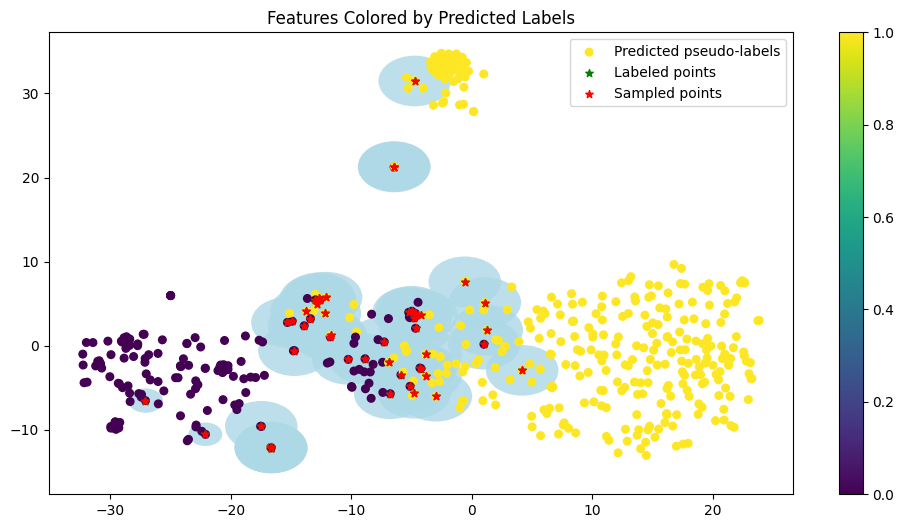

In [21]:
print('Plotting features...')
# Visualize the features in 2D using t-SNE
tsne = TSNE(n_components=2, random_state = 42)
features_2d = tsne.fit_transform(features)

# Extract the 2D coordinates for the sampled points
sampled_points = features_2d[active_set]
labeled_points =  features_2d[lSet]


S = min(15000 / features_2d.shape[0], 30)

plt.figure(figsize=(12, 6))
# Add circles of radius delta around points from lSet
ax = plt.gca()
for i, point_idx in enumerate(lSet):
    point_2d = features_2d[point_idx]
    delta = float(lSet_deltas[i])
    circle = Circle(point_2d, radius=delta, fill=True, facecolor='lightblue', alpha=0.8, linestyle='-', linewidth=0.6)
    ax.add_patch(circle)
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=pseudo_labels, cmap='viridis', s=S, label = 'Predicted pseudo-labels')
# Highlight the sampled points and labeled points in a different color or marker (e.g., red stars)
plt.scatter(labeled_points[:, 0], labeled_points[:, 1], c='green', edgecolors='green', marker='*', s=S*1.04, label='Labeled points')
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], c='red', edgecolors='red', marker='*', s=S*1.05, label='Sampled points')
# plt.scatter(sampled_points_2d[:, 0], sampled_points_2d[:, 1], c=pred_df.loc[pred_df['true_label'].notna(),'true_label'], cmap='viridis', s=31)
plt.colorbar()
plt.title("Features Colored by Predicted Labels")

# Add a legend to highlight the sampled points
plt.legend()
# Save the plot to the dcom folder
plot_path = os.path.join(output_dir, 'features_plot.png')
plt.savefig(plot_path)
plt.show()


### 6. Save data for the next round
Finally, save the pred_df DataFrame to a pickle file in case the notebook is reset betwwen rounds. To select new samples, you can run the 6 steps above again

In [ ]:

if save_pred_df:
    with open(os.path.join(output_dir,'pred_df.pkl'), 'wb') as f:
        pickle.dump(pred_df, f)
    print('Saved pred_df file \n')